# 导入使用的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

# 读入数据

In [2]:
df_sales = pd.read_csv(r'./sales.csv')
df_products = pd.read_csv(r'./products.csv')

# 查看表的信息

In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90718 entries, 0 to 90717
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_code     90718 non-null  object
 1   product_code  90718 non-null  object
 2   price         90718 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


In [4]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_code  95 non-null     object
 1   product_type  95 non-null     object
 2   price         95 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


# 归一化价格

## 统计价格最大值最小值

In [5]:
total_product = df_products.groupby("product_type")
max_price = total_product["price"].max()
min_price = total_product["price"].min()
df_max_price = pd.DataFrame({'product_type':max_price.index,'max_price':max_price.values})
df_min_price = pd.DataFrame({'product_type':min_price.index,'min_price':min_price.values})
df_price = pd.merge(df_max_price, df_min_price, how="left", on="product_type")
new_df_products = pd.merge(df_products, df_price, how="left", on="product_type")
df_price.head()


,product_type,max_price,min_price
0,D0001,149000,13400
1,D0002,52500,14900
2,D0003,3490,1088
3,D0004,39900,1980
4,D0005,8888,2788


In [6]:
new_df_products.head()

,product_code,product_type,price,max_price,min_price
0,SPct0001,D0001,22888,149000,13400
1,SPct0002,D0001,149000,149000,13400
2,SPct0003,D0001,89900,149000,13400
3,SPct0004,D0001,38490,149000,13400
4,SPct0005,D0001,13400,149000,13400


## 归一化

In [7]:
new_df_products["normalization"] = (new_df_products["price"]-new_df_products["min_price"])/(new_df_products["max_price"]-new_df_products["min_price"])
del new_df_products["max_price"], new_df_products["min_price"]
new_df_products.head()

,product_code,product_type,price,normalization
0,SPct0001,D0001,22888,0.069971
1,SPct0002,D0001,149000,1.000000
2,SPct0003,D0001,89900,0.564159
3,SPct0004,D0001,38490,0.185029
4,SPct0005,D0001,13400,0.000000


# 统计顾客买各种价位产品的数量

In [8]:
df_sales_products = pd.merge(df_sales, new_df_products, how="left", on="product_code")
df_sales_products

,user_code,product_code,price_x,product_type,price_y,normalization
0,Ben00001,SPct0051,3590,D0011,3590,0.362319
1,Ben00001,SPct0051,3590,D0011,3590,0.362319
2,Ben00001,SPct0054,28500,D0009,28500,1.000000
3,Ben00001,SPct0073,1380,D0006,1380,0.000000
4,Ben00001,SPct0064,3790,D0010,3790,0.102912
...,...,...,...,...,...,...
90713,Ben09206,SPct0018,30900,D0007,30900,0.424968
90714,Ben09206,SPct0082,1088,D0003,1088,0.000000
90715,Ben09206,SPct0073,1380,D0006,1380,0.000000
90716,Ben09206,SPct0003,89900,D0001,89900,0.564159


## 低端产品

In [9]:
df_low_cost = df_sales_products[(df_sales_products["normalization"]<=0.333333)]
df_low_cost_count = df_low_cost.groupby([df_low_cost["user_code"]]).size().reset_index(name='low_cost_counts')

# 中端产品

In [10]:
df_medium_cost = df_sales_products[(df_sales_products["normalization"]>0.333333)&(df_sales_products["normalization"]<=0.666667)]
df_medium_cost_count = df_medium_cost.groupby([df_medium_cost["user_code"]]).size().reset_index(name='medium_cost_counts')

## 高端产品

In [11]:
df_high_cost = df_sales_products[(df_sales_products["normalization"]>0.666667)&(df_sales_products["normalization"]<=1.000000)]
df_high_cost_count = df_high_cost.groupby([df_high_cost["user_code"]]).size().reset_index(name='high_cost_counts')

## 合并统计数据

In [12]:
df_users = df_sales.groupby("user_code").size().reset_index(name="total")
del df_users["total"]

for df in [df_low_cost_count, df_medium_cost_count, df_high_cost_count]:
    df_users = pd.merge(df_users, df, how="left", on="user_code")

df_users = df_users.fillna(0)
df_users[["low_cost_counts", "medium_cost_counts", "high_cost_counts"]] = df_users[["low_cost_counts", "medium_cost_counts", "high_cost_counts"]].astype(int)

df_users.head()

,user_code,low_cost_counts,medium_cost_counts,high_cost_counts
0,Ben00001,4,2,1
1,Ben00002,7,2,0
2,Ben00003,8,1,5
3,Ben00004,8,4,2
4,Ben00005,7,2,0


In [13]:
# max= np.max(df_users['low_cost_counts'])
# min= np.min(df_users['low_cost_counts'])
# df_users["low_cost_counts"] = (df_users["low_cost_counts"]-min)/(max-min)
# max= np.max(df_users['medium_cost_counts'])
# min= np.min(df_users['medium_cost_counts'])
# df_users["medium_cost_counts"] = (df_users["medium_cost_counts"]-min)/(max-min)
# max= np.max(df_users['high_cost_counts'])
# min= np.min(df_users['high_cost_counts'])
# df_users["high_cost_counts"] = (df_users["high_cost_counts"]-min)/(max-min)

df_users["all_counts"] = df_users["low_cost_counts"] + df_users["medium_cost_counts"] + df_users["high_cost_counts"]
df_users["low_cost_counts"] = df_users["low_cost_counts"]/df_users["all_counts"]
df_users["medium_cost_counts"] = df_users["medium_cost_counts"]/df_users["all_counts"]
df_users["high_cost_counts"] = df_users["high_cost_counts"]/df_users["all_counts"]
del df_users["all_counts"]
df_users.head()


,user_code,low_cost_counts,medium_cost_counts,high_cost_counts
0,Ben00001,0.571429,0.285714,0.142857
1,Ben00002,0.777778,0.222222,0.000000
2,Ben00003,0.571429,0.071429,0.357143
3,Ben00004,0.571429,0.285714,0.142857
4,Ben00005,0.777778,0.222222,0.000000


# 聚类划分用户定位

In [14]:
count_data = np.array(df_users[["low_cost_counts", "medium_cost_counts", "high_cost_counts"]])

In [15]:
np.mean(count_data,axis=0)

array([0.64344919, 0.2191532 , 0.13739761])

In [16]:
def calculate_distance(point1, point2):
    return np.sqrt(np.sum(np.square(point1-point2)))

def plot_fig(data_cls1, data_cls2, data_cls3, center):
    fig = plt.figure()
    ax = Axes3D(fig)

    data_x1 = data_cls1[:200,0]
    data_y1 = data_cls1[:200,1]
    data_z1 = data_cls1[:200,2]
    ax.scatter(data_x1, data_y1, data_z1, c='y')
    
    data_x2 = data_cls2[:200,0]
    data_y2 = data_cls2[:200,1]
    data_z2 = data_cls2[:200,2]
    ax.scatter(data_x2, data_y2, data_z2, c='g')
    
    data_x3 = data_cls3[:200,0]
    data_y3 = data_cls3[:200,1]
    data_z3 = data_cls3[:200,2]
    ax.scatter(data_x3, data_y3, data_z3, c='b')

    ax.scatter(center[0][0], center[0][1], center[0][2], c='r', marker='^')
    ax.scatter(center[1][0], center[1][1], center[1][2], c='r', marker='o')
    ax.scatter(center[2][0], center[2][1], center[2][2], c='r', marker='x')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # 仰角和方位角
    ax.view_init(elev=15, azim=45)
    # ax.invert_yaxis()

def dbi(k, data, cls, center):
    avg_si = np.zeros(k)
    for label in range(k):
        data_label = data[cls==label]
        if len(data_label) == 0:
            avg_si[label] = 0
        else:
            avg_si[label] = np.mean(np.sqrt(np.sum(np.square(data_label-center[label]), axis=1)))
    
    kdbi = 0
    for i in range(k):
        max_val = -float("inf")
        for j in range(k):
            if i == j:
                continue
            max_val = max(max_val, (avg_si[i]+avg_si[j])/ calculate_distance(center[i], center[j]))
        kdbi += max_val
    return kdbi/k

def k_means(data, k):
    len_data = len(data)
    
    # rarray = np.random.random(size=k)
    # rarray = np.floor(rarray*len_data)
    # rarray = rarray.astype(int)
    # print("数据初始中心索引:", rarray)
    # center = data[rarray]

    center = [[0.8, 0.1, 0.1],[0.1, 0.8, 0.1],[0.1, 0.1, 0.8]]
    center = np.array(center)
    
    print("初始中心坐标:\n", center)
    cls = -1 * np.ones([len_data], int)

    while True:
        new_cls = copy.deepcopy(cls)
        for i in range(len_data):
            min_distance = np.inf
            for j in range(k):
                temp_distance = calculate_distance(center[j], data[i])
                if temp_distance < min_distance:
                    min_distance = temp_distance
                    cls[i] = j
            center[cls[i]] = np.mean(data[cls==cls[i]], axis=0)
        if np.array_equal(new_cls, cls):
            break    
    print("聚类后中心坐标:\n", center)

    data_1 = data[cls==0]
    data_2 = data[cls==1]
    data_3 = data[cls==2]
    plot_fig(data_1, data_2, data_3, center)

    dbi_val = dbi(k, data, cls, center)
    print("聚类评价指标DBI的值为:", dbi_val)

初始中心坐标:
 [[0.8 0.1 0.1]
 [0.1 0.8 0.1]
 [0.1 0.1 0.8]]
聚类后中心坐标:
 [[0.78440624 0.12036883 0.09522493]
 [0.50526233 0.38916712 0.10557056]
 [0.41832406 0.1607692  0.42090674]]
聚类评价指标DBI的值为: 0.9984700663188854


d:\Environment\python_venv\pinn-demo\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


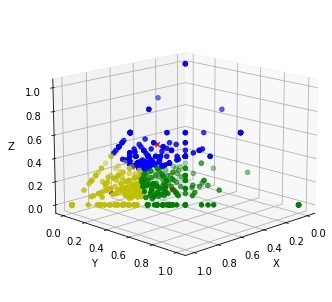

In [17]:
k_means(count_data, 3)